In [153]:
import xarray as xr
import dask.array as da
import rioxarray
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cartopy.crs as ccrs
import geopandas as gpd
import numpy as np
from shapely.geometry import mapping

# Load data

In [2]:
import os
DATA_DIR = "/mnt/d/data"
os.listdir(DATA_DIR)

['fire_perimeters']

### Load perimeters

In [9]:
os.listdir(f"{DATA_DIR}/fire_perimeters")

['WFIGS_Interagency_Perimeters_Current_-2078219868963267088(1).geojson',
 'WFIGS_Interagency_Perimeters_Current_-2078219868963267088.geojson']

,OBJECTID,poly_SourceOID,poly_IncidentName,poly_FeatureCategory,poly_MapMethod,poly_GISAcres,poly_DeleteThis,poly_FeatureAccess,poly_FeatureStatus,poly_IsVisible,...,attr_ModifiedOnDateTime_dt,attr_Source,attr_ActiveFireCandidate,attr_IsCpxChild,attr_CpxName,attr_CpxID,attr_SourceGlobalID,GlobalID,attr_IncidentComplexityLevel,geometry
1,36398,172,PALISADES,Wildfire Daily Fire Perimeter,IR Image Interpretation,23448.000000,No,Public,Approved,Yes,...,"Tue, 28 Jan 2025 01:02:55 GMT",IRWIN,1,0,None,None,{35C19D7C-FEDA-42F8-AD76-9B094E783801},2a11c9e3-3295-4623-8c53-4e9a192ae0f3,Type 1 Incident,"MULTIPOLYGON (((-118.56093 34.04408, -118.5609..."
2,36410,615,Eaton,Wildfire Daily Fire Perimeter,Mixed Methods,14021.108712,No,Public,Approved,Yes,...,"Tue, 28 Jan 2025 01:38:46 GMT",IRWIN,1,0,None,None,{DB7CE9EC-16E0-4513-93D5-95E12703F2F9},52bfca63-1058-40fe-a4b8-ec17b36361c1,Type 3 Incident,"MULTIPOLYGON (((-118.08301 34.23769, -118.0830..."


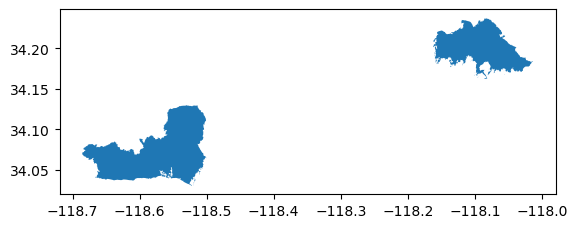

In [41]:
gdf = (
    gpd.read_file(f"{DATA_DIR}/fire_perimeters/WFIGS_Interagency_Perimeters_Current_-2078219868963267088(1).geojson")
    .loc[lambda df: df.poly_IncidentName.isin(["PALISADES", "Eaton"])]
    .to_crs("EPSG:4326")
)
gdf.plot()
gdf.head()

### Load and format raw ERA5 data

In [95]:
LA_BOUNDING_BOX = {
    "lat_min": 33.5,  # Southernmost point
    "lat_max": 34.8,  # Northernmost point
    "lon_min": -119.0, # Westernmost point
    "lon_max": -117.5  # Easternmost point
}

def filter_dataset_by_bbox(ds, lat_min, lat_max, lon_min, lon_max):
    return ds.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))

In [96]:
era5_ds = xr.open_dataset(f"{DATA_DIR}/era5/era5_derived_hourly.zarr", chunks="auto").sortby("latitude")
era5_ds = filter_dataset_by_bbox(
    era5_ds,
    **LA_BOUNDING_BOX,
)
era5_ds = era5_ds.rio.write_crs("EPSG:4326")
era5_ds

<xarray.Dataset> Size: 753MB
Dimensions:      (latitude: 6, valid_time: 648988, longitude: 6)
Coordinates:
  * latitude     (latitude) float64 48B 33.53 33.78 34.03 34.28 34.53 34.78
  * longitude    (longitude) float64 48B -118.9 -118.7 -118.4 ... -117.9 -117.7
  * valid_time   (valid_time) datetime64[ns] 5MB 1951-01-01 ... 2025-01-13T03...
    spatial_ref  int64 8B 0
Data variables:
    tp           (valid_time, latitude, longitude) float32 93MB dask.array<chunksize=(43000, 6, 6), meta=np.ndarray>
    fosberg      (valid_time, latitude, longitude) float32 93MB dask.array<chunksize=(43000, 6, 6), meta=np.ndarray>
    u10          (valid_time, latitude, longitude) float32 93MB dask.array<chunksize=(43000, 6, 6), meta=np.ndarray>
    t2m          (valid_time, latitude, longitude) float32 93MB dask.array<chunksize=(43000, 6, 6), meta=np.ndarray>
    v10          (valid_time, latitude, longitude) float32 93MB dask.array<chunksize=(43000, 6, 6), meta=np.ndarray>
    wind         (valid_time, latitude, longitude) float32 93MB dask.array<chunksize=(43000, 6, 6), meta=np.ndarray>
    rh           (valid_time, latitude, longitude) float32 93MB dask.array<chunksize=(43000, 6, 6), meta=np.ndarray>
    d2m          (valid_time, latitude, longitude) float32 93MB dask.array<chunksize=(43000, 6, 6), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-01-16T21:06 GRIB to CDM+CF via cfgrib-0.9.1...

# Mask ERA5 data for Eaton and Palisades fires

In [70]:
masks = []

# Iterate over each fire perimeter
for _, row in gdf.iterrows():
    fire_name = row.poly_IncidentName
    fire_geom = row.geometry
    clipped = era5_ds.rio.clip([mapping(fire_geom)], era5_ds.rio.crs, drop=True, all_touched=True)
    masks.append(clipped[["latitude", "longitude"]].to_dataframe().assign(fire_name=fire_name))

mask_df = pd.concat(masks).reset_index()
mask_df

,latitude,longitude,spatial_ref,fire_name
0,34.03,-118.65,0,PALISADES
1,34.03,-118.40,0,PALISADES
2,34.28,-118.15,0,Eaton
3,34.28,-117.90,0,Eaton


In [126]:
pal_ds = era5_ds.where(
    ((era5_ds.latitude == 34.03) & (era5_ds.longitude == -118.4)) |
    ((era5_ds.latitude == 34.03) & (era5_ds.longitude == -118.65)),
    drop=True
)

eat_ds = era5_ds.where(
    ((era5_ds.latitude == 34.28) & (era5_ds.longitude == -118.15)) |
    ((era5_ds.latitude == 34.28) & (era5_ds.longitude == -117.9)),
    drop=True
)
pal_ds

<xarray.Dataset> Size: 47MB
Dimensions:      (valid_time: 648988, latitude: 1, longitude: 2)
Coordinates:
  * latitude     (latitude) float64 8B 34.03
  * longitude    (longitude) float64 16B -118.7 -118.4
  * valid_time   (valid_time) datetime64[ns] 5MB 1951-01-01 ... 2025-01-13T03...
    spatial_ref  int64 8B 0
Data variables:
    tp           (valid_time, latitude, longitude) float32 5MB dask.array<chunksize=(43000, 1, 2), meta=np.ndarray>
    fosberg      (valid_time, latitude, longitude) float32 5MB dask.array<chunksize=(43000, 1, 2), meta=np.ndarray>
    u10          (valid_time, latitude, longitude) float32 5MB dask.array<chunksize=(43000, 1, 2), meta=np.ndarray>
    t2m          (valid_time, latitude, longitude) float32 5MB dask.array<chunksize=(43000, 1, 2), meta=np.ndarray>
    v10          (valid_time, latitude, longitude) float32 5MB dask.array<chunksize=(43000, 1, 2), meta=np.ndarray>
    wind         (valid_time, latitude, longitude) float32 5MB dask.array<chunksize=(43000, 1, 2), meta=np.ndarray>
    rh           (valid_time, latitude, longitude) float32 5MB dask.array<chunksize=(43000, 1, 2), meta=np.ndarray>
    d2m          (valid_time, latitude, longitude) float32 5MB dask.array<chunksize=(43000, 1, 2), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-01-16T21:06 GRIB to CDM+CF via cfgrib-0.9.1...

# Aggregate to daily

In [127]:
def daily_resample(ds):
    wind_mean = ds["wind"].resample(valid_time="1D").mean()
    avg_u10 = ds["u10"].resample(valid_time="1D").mean()
    avg_v10 = ds["v10"].resample(valid_time="1D").mean()
    wind = ds["wind"].resample(valid_time="1D").mean()
    ffwi = ds["fosberg"].resample(valid_time="1D").mean()

    ###  mean standardized wind direction is between north-northwest (330 deg) 
    # and clockwise to south-southeast (120 deg)
    wind_direction = (np.arctan2(-avg_u10, -avg_v10) * (180 / da.pi)) % 360
    wind_mask = ((wind_direction >= 330) | (wind_direction <= 120))
    wind_indicator = wind_mask.astype(np.uint8)
    
    ds = xr.Dataset({
        "wind_mean": wind,
        "u10": avg_u10,
        "v10": avg_v10,
        "wind": wind,
        "ffwi": ffwi,
        "condition_2": wind_indicator,
    })
    return ds

pal_ds = daily_resample(pal_ds)
eat_ds = daily_resample(eat_ds)
eat_ds

<xarray.Dataset> Size: 1MB
Dimensions:      (latitude: 1, longitude: 2, valid_time: 27042)
Coordinates:
  * latitude     (latitude) float64 8B 34.28
  * longitude    (longitude) float64 16B -118.2 -117.9
    spatial_ref  int64 8B 0
  * valid_time   (valid_time) datetime64[ns] 216kB 1951-01-01 ... 2025-01-13
Data variables:
    wind_mean    (valid_time, latitude, longitude) float32 216kB dask.array<chunksize=(1792, 1, 2), meta=np.ndarray>
    u10          (valid_time, latitude, longitude) float32 216kB dask.array<chunksize=(1792, 1, 2), meta=np.ndarray>
    v10          (valid_time, latitude, longitude) float32 216kB dask.array<chunksize=(1792, 1, 2), meta=np.ndarray>
    wind         (valid_time, latitude, longitude) float32 216kB dask.array<chunksize=(1792, 1, 2), meta=np.ndarray>
    ffwi         (valid_time, latitude, longitude) float32 216kB dask.array<chunksize=(1792, 1, 2), meta=np.ndarray>
    condition_2  (valid_time, latitude, longitude) uint8 54kB dask.array<chunksize=(1792, 1, 2), meta=np.ndarray>

# Get 90th and 97th percentiles for FFWI

In [139]:
pal_sm = pal_ds.ffwi.mean(dim=["latitude", "longitude"])
pal_q90 = pal_sm.quantile(0.90, dim="valid_time")
pal_q97 = pal_sm.quantile(0.97, dim="valid_time")

eat_sm = eat_ds.ffwi.mean(dim=["latitude", "longitude"])
eat_q90 = eat_sm.quantile(0.90, dim="valid_time")
eat_q97 = eat_sm.quantile(0.97, dim="valid_time")

def assign_quantile_conditions(ds, q90, q97):
    return (
        ds.mean(dim=["latitude", "longitude"]).assign(
            condition_1=lambda ds: (ds.ffwi >= q90.values),
            condition_1_extreme=lambda ds: (ds.ffwi >= q97.values),
        )
    )

pal_ds = assign_quantile_conditions(pal_ds, pal_q90, pal_q97)
eat_ds = assign_quantile_conditions(eat_ds, eat_q90, eat_q97)
eat_ds


<xarray.Dataset> Size: 1MB
Dimensions:              (valid_time: 27042)
Coordinates:
    spatial_ref          int64 8B 0
  * valid_time           (valid_time) datetime64[ns] 216kB 1951-01-01 ... 202...
Data variables:
    wind_mean            (valid_time) float32 108kB dask.array<chunksize=(1792,), meta=np.ndarray>
    u10                  (valid_time) float32 108kB dask.array<chunksize=(1792,), meta=np.ndarray>
    v10                  (valid_time) float32 108kB dask.array<chunksize=(1792,), meta=np.ndarray>
    wind                 (valid_time) float32 108kB dask.array<chunksize=(1792,), meta=np.ndarray>
    ffwi                 (valid_time) float32 108kB dask.array<chunksize=(1792,), meta=np.ndarray>
    condition_2          (valid_time) float64 216kB dask.array<chunksize=(1792,), meta=np.ndarray>
    condition_1          (valid_time) bool 27kB dask.array<chunksize=(1792,), meta=np.ndarray>
    condition_1_extreme  (valid_time) bool 27kB dask.array<chunksize=(1792,), meta=np.ndarray>

In [144]:
eat_df = eat_ds[["valid_time", "wind", "condition_1", "condition_1_extreme", "condition_2"]].to_dataframe()
pal_df = pal_ds[["valid_time", "wind", "condition_1", "condition_1_extreme", "condition_2"]].to_dataframe()

analysis_df = (
    pd.concat([
        eat_df.assign(fire_name="Eaton"),
        pal_df.assign(fire_name="Palisades"),
    ])
    .assign(
        saw_day=lambda df: (df.condition_1) & (df.condition_2),
        esaw_day=lambda df: (df.condition_1_extreme) & (df.condition_2),
    )
)
analysis_df.head()

,wind,condition_1,condition_1_extreme,condition_2,spatial_ref,fire_name,saw_day,esaw_day
valid_time,,,,,,,,
1951-01-01,2.628524,True,False,1.0,0,Eaton,True,False
1951-01-02,1.664387,False,False,1.0,0,Eaton,False,False
1951-01-03,1.125025,False,False,0.0,0,Eaton,False,False
1951-01-04,1.038689,False,False,0.0,0,Eaton,False,False
1951-01-05,1.049835,False,False,1.0,0,Eaton,False,False


# Palisades

In [173]:
sub_df = analysis_df.loc[lambda df: df.fire_name == "Palisades"].reset_index()
sub_df

,valid_time,wind,condition_1,condition_1_extreme,condition_2,spatial_ref,fire_name,saw_day,esaw_day
0,1951-01-01,3.189638,True,False,1.0,0,Palisades,True,False
1,1951-01-02,2.281070,False,False,1.0,0,Palisades,False,False
2,1951-01-03,1.333098,False,False,0.5,0,Palisades,False,False
3,1951-01-04,1.857749,False,False,0.0,0,Palisades,False,False
4,1951-01-05,1.489351,False,False,1.0,0,Palisades,False,False
...,...,...,...,...,...,...,...,...,...
27037,2025-01-09,2.725553,True,False,1.0,0,Palisades,True,False
27038,2025-01-10,2.328828,True,False,1.0,0,Palisades,True,False
27039,2025-01-11,1.732618,False,False,1.0,0,Palisades,False,False
27040,2025-01-12,3.283114,True,True,1.0,0,Palisades,True,True


/tmp/ipykernel_1893/3578474972.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="valid_time_str", y="wind", data=sub_df_sorted, palette="Blues")


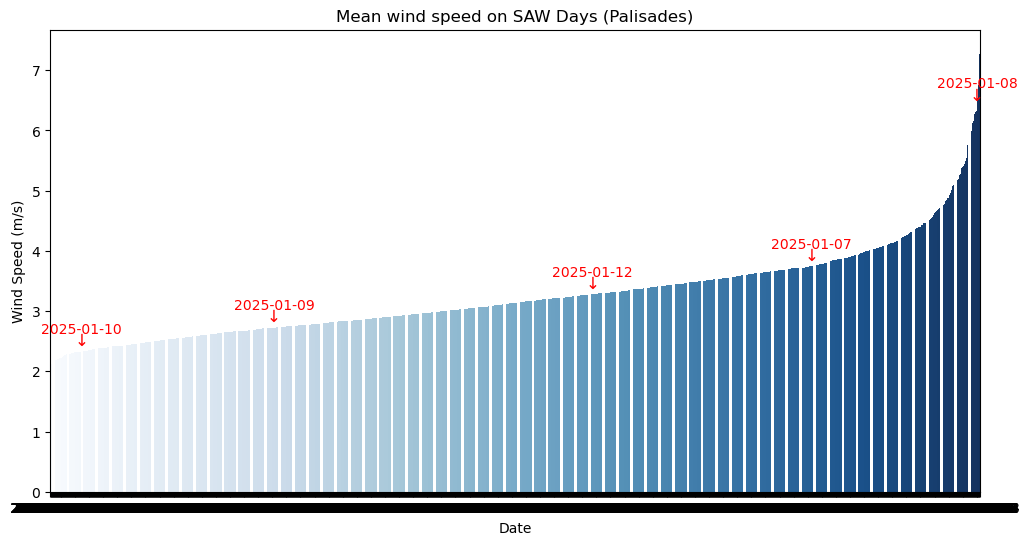

In [174]:
# Convert valid_time to datetime if not already
sub_df["valid_time"] = pd.to_datetime(sub_df["valid_time"])

# Filter & sort by wind
sub_df_sorted = sub_df.loc[lambda df: df.saw_day == 1].sort_values("wind", ascending=True)

# Convert valid_time to string for plotting
sub_df_sorted["valid_time_str"] = sub_df_sorted["valid_time"].dt.strftime("%Y-%m-%d")

# Identify points between 2025-01-01 and 2025-01-14
highlight_points = sub_df_sorted[
    (sub_df_sorted["valid_time"] >= "2025-01-01") & 
    (sub_df_sorted["valid_time"] <= "2025-01-14")
]

# Set figure size
plt.figure(figsize=(12, 6))

# Create a bar plot using string-based x-axis
ax = sns.barplot(x="valid_time_str", y="wind", data=sub_df_sorted, palette="Blues")

# Add small red arrows to highlight points
for index, row in highlight_points.iterrows():
    plt.annotate(
        "↓", 
        (row["valid_time_str"], row["wind"] + 0.1),  # Position slightly above the bar
        color="red", fontsize=12, ha='center'
    )
    # Add the date label in condensed format (MM-DD)
    plt.annotate(
        row["valid_time"].strftime("%Y-%m-%d"),
        (row["valid_time_str"], row["wind"] + 0.3),  # Slightly above the arrow
        color="red", fontsize=10, ha='center'
    )

# Formatting
plt.xlabel("Date")
plt.ylabel("Wind Speed (m/s)")
plt.title("Mean wind speed on SAW Days (Palisades)")
# plt.xticks(rotation=45)  # Rotate x-axis labels for readability

plt.savefig("paliades_saw.png", dpi=300, bbox_inches="tight")

# Show plot
plt.show()

/tmp/ipykernel_1893/1035010081.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="valid_time_str", y="wind", data=sub_df_sorted, palette="Blues")


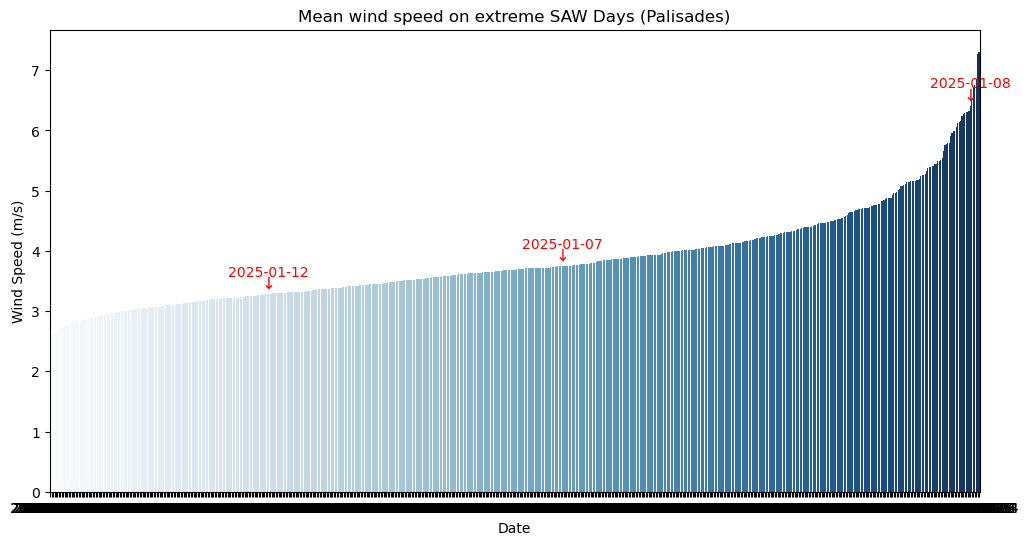

In [175]:
# Convert valid_time to datetime if not already
sub_df["valid_time"] = pd.to_datetime(sub_df["valid_time"])

# Filter & sort by wind
sub_df_sorted = sub_df.loc[lambda df: df.esaw_day == 1].sort_values("wind", ascending=True)

# Convert valid_time to string for plotting
sub_df_sorted["valid_time_str"] = sub_df_sorted["valid_time"].dt.strftime("%Y-%m-%d")

# Identify points between 2025-01-01 and 2025-01-14
highlight_points = sub_df_sorted[
    (sub_df_sorted["valid_time"] >= "2025-01-01") & 
    (sub_df_sorted["valid_time"] <= "2025-01-14")
]

# Set figure size
plt.figure(figsize=(12, 6))

# Create a bar plot using string-based x-axis
ax = sns.barplot(x="valid_time_str", y="wind", data=sub_df_sorted, palette="Blues")

# Add small red arrows to highlight points
for index, row in highlight_points.iterrows():
    plt.annotate(
        "↓", 
        (row["valid_time_str"], row["wind"] + 0.1),  # Position slightly above the bar
        color="red", fontsize=12, ha='center'
    )
    # Add the date label in condensed format (MM-DD)
    plt.annotate(
        row["valid_time"].strftime("%Y-%m-%d"),
        (row["valid_time_str"], row["wind"] + 0.3),  # Slightly above the arrow
        color="red", fontsize=10, ha='center'
    )

# Formatting
plt.xlabel("Date")
plt.ylabel("Wind Speed (m/s)")
plt.title("Mean wind speed on extreme SAW Days (Palisades)")
# plt.xticks(rotation=45)  # Rotate x-axis labels for readability

plt.savefig("paliades_esaw.png", dpi=300, bbox_inches="tight")

# Show plot
plt.show()

# Eaton

In [176]:
sub_df = analysis_df.loc[lambda df: df.fire_name == "Eaton"].reset_index()
sub_df

,valid_time,wind,condition_1,condition_1_extreme,condition_2,spatial_ref,fire_name,saw_day,esaw_day
0,1951-01-01,2.628524,True,False,1.0,0,Eaton,True,False
1,1951-01-02,1.664387,False,False,1.0,0,Eaton,False,False
2,1951-01-03,1.125025,False,False,0.0,0,Eaton,False,False
3,1951-01-04,1.038689,False,False,0.0,0,Eaton,False,False
4,1951-01-05,1.049835,False,False,1.0,0,Eaton,False,False
...,...,...,...,...,...,...,...,...,...
27037,2025-01-09,2.741091,True,True,1.0,0,Eaton,True,True
27038,2025-01-10,2.288334,True,False,1.0,0,Eaton,True,False
27039,2025-01-11,1.438421,False,False,1.0,0,Eaton,False,False
27040,2025-01-12,2.708519,True,True,1.0,0,Eaton,True,True


/tmp/ipykernel_1893/38864947.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="valid_time_str", y="wind", data=sub_df_sorted, palette="Blues")


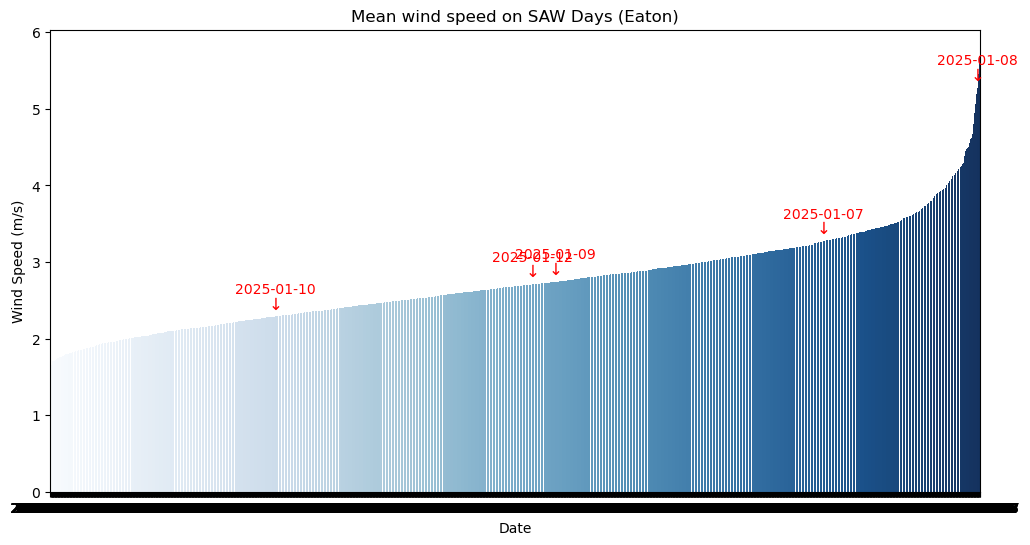

In [177]:
# Convert valid_time to datetime if not already
sub_df["valid_time"] = pd.to_datetime(sub_df["valid_time"])

# Filter & sort by wind
sub_df_sorted = sub_df.loc[lambda df: df.saw_day == 1].sort_values("wind", ascending=True)

# Convert valid_time to string for plotting
sub_df_sorted["valid_time_str"] = sub_df_sorted["valid_time"].dt.strftime("%Y-%m-%d")

# Identify points between 2025-01-01 and 2025-01-14
highlight_points = sub_df_sorted[
    (sub_df_sorted["valid_time"] >= "2025-01-01") & 
    (sub_df_sorted["valid_time"] <= "2025-01-14")
]

# Set figure size
plt.figure(figsize=(12, 6))

# Create a bar plot using string-based x-axis
ax = sns.barplot(x="valid_time_str", y="wind", data=sub_df_sorted, palette="Blues")

# Add small red arrows to highlight points
for index, row in highlight_points.iterrows():
    plt.annotate(
        "↓", 
        (row["valid_time_str"], row["wind"] + 0.1),  # Position slightly above the bar
        color="red", fontsize=12, ha='center'
    )
    # Add the date label in condensed format (MM-DD)
    plt.annotate(
        row["valid_time"].strftime("%Y-%m-%d"),
        (row["valid_time_str"], row["wind"] + 0.3),  # Slightly above the arrow
        color="red", fontsize=10, ha='center'
    )

# Formatting
plt.xlabel("Date")
plt.ylabel("Wind Speed (m/s)")
plt.title("Mean wind speed on SAW Days (Eaton)")
# plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.savefig("eaton_saw.png", dpi=300, bbox_inches="tight")
# Show plot
plt.show()

/tmp/ipykernel_1893/3612088773.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="valid_time_str", y="wind", data=sub_df_sorted, palette="Blues")


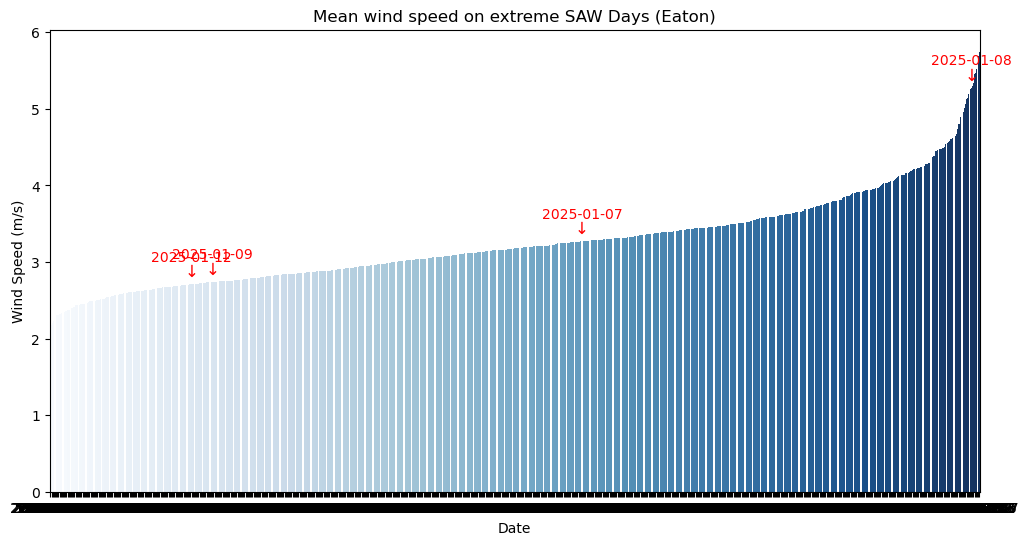

In [178]:
# Convert valid_time to datetime if not already
sub_df["valid_time"] = pd.to_datetime(sub_df["valid_time"])

# Filter & sort by wind
sub_df_sorted = sub_df.loc[lambda df: df.esaw_day == 1].sort_values("wind", ascending=True)

# Convert valid_time to string for plotting
sub_df_sorted["valid_time_str"] = sub_df_sorted["valid_time"].dt.strftime("%Y-%m-%d")

# Identify points between 2025-01-01 and 2025-01-14
highlight_points = sub_df_sorted[
    (sub_df_sorted["valid_time"] >= "2025-01-01") & 
    (sub_df_sorted["valid_time"] <= "2025-01-14")
]

# Set figure size
plt.figure(figsize=(12, 6))

# Create a bar plot using string-based x-axis
ax = sns.barplot(x="valid_time_str", y="wind", data=sub_df_sorted, palette="Blues")

# Add small red arrows to highlight points
for index, row in highlight_points.iterrows():
    plt.annotate(
        "↓", 
        (row["valid_time_str"], row["wind"] + 0.1),  # Position slightly above the bar
        color="red", fontsize=12, ha='center'
    )
    # Add the date label in condensed format (MM-DD)
    plt.annotate(
        row["valid_time"].strftime("%Y-%m-%d"),
        (row["valid_time_str"], row["wind"] + 0.3),  # Slightly above the arrow
        color="red", fontsize=10, ha='center'
    )

# Formatting
plt.xlabel("Date")
plt.ylabel("Wind Speed (m/s)")
plt.title("Mean wind speed on extreme SAW Days (Eaton)")
# plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.savefig("eaton_esaw.png", dpi=300, bbox_inches="tight")
# Show plot
plt.show()